# Introduction

For starters we will use ten different actors, denoted by different video id:s.


We will apply LOGO CV (Leave One Group Out cross-validation)

We will later have to take into account variables like mode (prosody or vocalization) and intensity (1-4) in the cross validation scheme. 

However for the first run it will be fine to include all without taking such factors into account.



In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn as sk
import scipy
from dotenv import load_dotenv

# Working dir

In [2]:
module_path = os.path.abspath(os.path.join('../../'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.sql_handling.execute_sql import execute_sql_pandas

# Paths

In [4]:
load_dotenv()

# path to save figures
output_path = os.getenv("VIDEO_OUT")

# Global configuration path
glob_conf_path = '../global_config.py'

# Load global variables

In [5]:
exec(open(glob_conf_path).read())

# Select data from DB

We only select data that satisfies following three conditions:

* Success == 1
* Confidence rate >= 0.98
* mix (mixed emotions) = False(0)

We also only select the following six video_ids: 'A101', 'A102', 'A18', 'A200'

In [6]:
AU_COLS = ['AU01_r',
'AU02_r',
'AU04_r',
'AU05_r',
'AU06_r',
'AU07_r',
'AU09_r',
'AU10_r',
'AU12_r',
'AU14_r',
'AU15_r',
'AU17_r',
'AU20_r',
'AU23_r',
'AU25_r',
'AU26_r',
'AU45_r']

In [7]:
#query = """SELECT filename,
#video_id,
#emotion_1,
#emotion_1_id,
#frame,
#success,
#confidence,
#AU01_r,
#AU02_r,
#AU04_r,
#AU05_r,
#AU06_r,
#AU07_r,
#AU09_r,
#AU10_r,
#AU12_r,
#AU14_r,
#AU15_r,
#AU17_r,
#AU20_r,
#AU23_r,
#AU25_r,
#AU26_r,
#AU45_r
#FROM openface
#WHERE mix = 0
#AND (intensity_level = 4 OR emotion_1 = 'neu')
#AND situation = 1 
#AND mode = 'v'
#AND video_id IN ('A101', 'A102', 'A18', 'A200', 'A303', 'A227', 'A21', 'A18');"""
#df, read_duration = execute_sql_pandas(query)

In [8]:
query = """SELECT filename,
video_id,
emotion_1,
emotion_1_id,
frame,
success,
confidence,
AU01_r,
AU02_r,
AU04_r,
AU05_r,
AU06_r,
AU07_r,
AU09_r,
AU10_r,
AU12_r,
AU14_r,
AU15_r,
AU17_r,
AU20_r,
AU23_r,
AU25_r,
AU26_r,
AU45_r
FROM openface
WHERE mix = 0;"""
df, read_duration = execute_sql_pandas(query)

In [9]:
print("query executed in: {} seconds".format(read_duration))

query executed in: 91.675 seconds


In [10]:
df

,filename,video_id,emotion_1,emotion_1_id,frame,success,confidence,AU01_r,AU02_r,AU04_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,A050121-R_awe_p_3,A050121-R,awe,18,1,1,1,0.00,0.00,0.73,...,1.25,1.61,0.05,0.00,1.86,0.04,0.23,0.00,1.53,0.29
1,A050121-R_awe_p_3,A050121-R,awe,18,2,1,1,0.00,0.00,0.66,...,1.27,1.54,0.07,0.00,1.68,0.03,0.23,0.00,1.41,0.13
2,A050121-R_awe_p_3,A050121-R,awe,18,3,1,1,0.00,0.00,0.63,...,1.32,1.52,0.08,0.00,1.57,0.03,0.20,0.00,1.32,0.04
3,A050121-R_awe_p_3,A050121-R,awe,18,4,1,1,0.00,0.00,0.63,...,1.33,1.51,0.10,0.00,1.57,0.01,0.17,0.00,1.33,0.23
4,A050121-R_awe_p_3,A050121-R,awe,18,5,1,1,0.00,0.00,0.69,...,1.33,1.53,0.10,0.04,1.59,0.01,0.11,0.00,1.41,0.67
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2266563,A91_sad_p_3,A91,sad,6,196,1,1,0.04,0.00,0.00,...,0.64,0.71,0.00,0.00,0.00,0.00,0.00,1.64,0.00,0.03
2266564,A91_sad_p_3,A91,sad,6,197,1,1,0.00,0.00,0.00,...,0.57,0.67,0.00,0.04,0.02,0.00,0.00,1.54,0.00,0.04
2266565,A91_sad_p_3,A91,sad,6,198,1,1,0.00,0.01,0.00,...,0.50,0.64,0.00,0.10,0.02,0.00,0.00,1.44,0.00,0.02
2266566,A91_sad_p_3,A91,sad,6,199,1,1,0.00,0.10,0.00,...,0.50,0.64,0.00,0.17,0.05,0.00,0.00,1.38,0.00,0.02


Total number of instances: 2266568

Number of Instances per File (before data cleaning)
A205_sad_v_3         1549
A205_sad_v_4         1437
A205_fea_v_1         1218
A223_ple_v_4         1216
A205_sad_v_1         1214
                     ... 
A303_hap_v_1           37
A050121-R_exc_p_3      34
A050121-R_fea_p_1      33
A337_cont_v_1          33
A303_tri_v_1           27
Name: filename, Length: 11062, dtype: int64



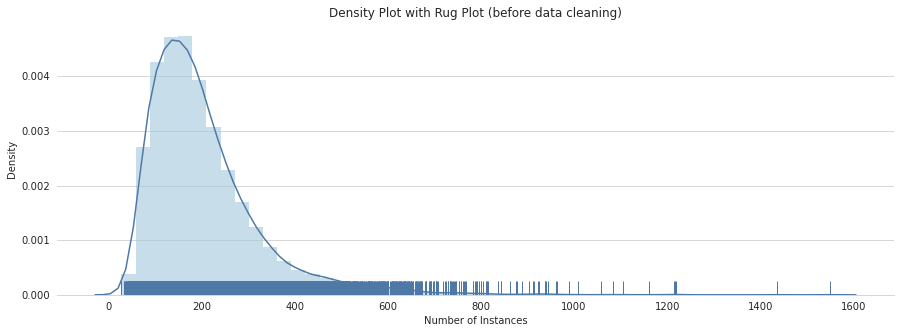


Number of Instances per Video id (before data cleaning)
A55          179899
A223         153763
A205         138796
A102         104285
A220          98338
A64           95564
A67           87523
A26           82101
A221          80275
A101          79726
A72           75630
A207          74833
A218          74039
A327          68931
A74           68177
A103          67451
A200          62877
A91           60390
A334          57489
A65           57067
A75           56230
A227          54594
A323          53944
A18           53269
A201          50629
A303          43081
A332          43056
A21           41127
A337          39395
A34           35888
A050121-R     28201
Name: video_id, dtype: int64


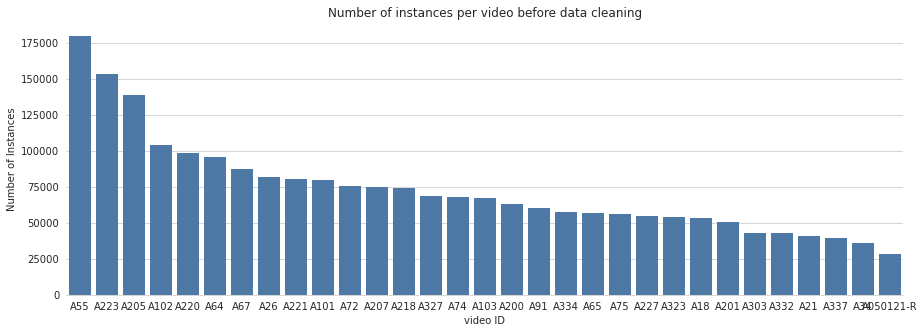


Number of Instances per Emotion (before data cleaning)
conc       60645
dou        60573
sad        59671
nos        59466
awe        58057
pea        57408
sha        56290
anx        56115
gui        55550
mov        55250
emb        55116
conf       53414
reg        53381
sat        53018
bor        52746
env        52044
ple        52040
ins        51670
sex        51261
ele        51239
disa       51220
hop        51151
neu        50846
ang        50781
neg_sur    50699
scha       50067
adm        49998
ten        49629
fea        49375
cont       49314
rej        49268
int        48395
gra        48310
pos_sur    48295
rel        47601
det        47587
pri        47531
disg       46975
dist       46814
exc        46439
sar        45917
amu        45731
hap        45271
tri        44400
Name: emotion_1, dtype: int64


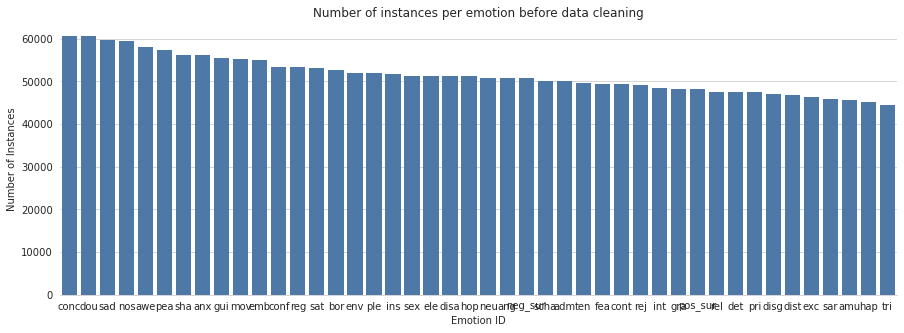


Number of Instances per Success Status (before data cleaning)
1    2257056
0       9512
Name: success, dtype: int64


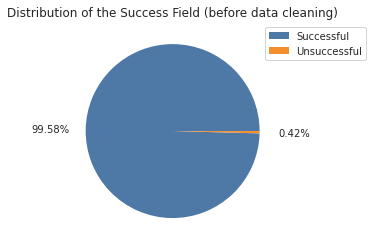


Percentage of Instances per Confidence Rate (before data cleaning)
0    0.00372
1    0.99628
Name: confidence, dtype: float64


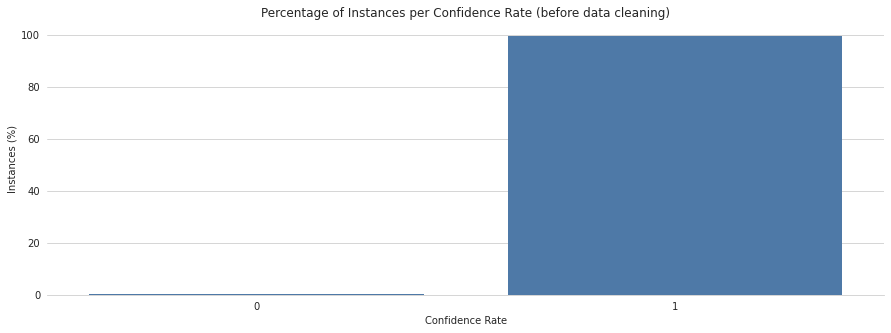

In [11]:
print("Total number of instances: {}".format(len(df)))
print()


print("Number of Instances per File (before data cleaning)")
file_val_counts_original = df["filename"].value_counts()
print(file_val_counts_original)
print()


x = file_val_counts_original.values
plt.figure(figsize=(15,5))
sns.distplot(x, rug=True, norm_hist=True,
             rug_kws={'color': blue_shades[0],'alpha':1},
             kde_kws={'color': blue_shades[0],'alpha':1},
             hist_kws={'color': blue_shades[1], 'alpha':0.6}
            )
plt.xlabel('Number of Instances')
plt.ylabel('Density')
plt.grid(False,axis='x')
plt.savefig(os.path.join(output_path,'charts','report_distribution_before_cleaning.svg'), bbox_inches = 'tight')
plt.title('Density Plot with Rug Plot (before data cleaning)')
plt.savefig(os.path.join(output_path,'charts','distribution_before_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()


print("Number of Instances per Video id (before data cleaning)")
video_val_counts_original = df["video_id"].value_counts()
print(video_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(video_val_counts_original.index, video_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.title("Number of instances per video before data cleaning")
plt.xlabel('video ID')
plt.ylabel('Number of Instances')
plt.show()
print()


print("Number of Instances per Emotion (before data cleaning)")
emotion_val_counts_original = df["emotion_1"].value_counts()
print(emotion_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(emotion_val_counts_original.index, emotion_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.title("Number of instances per emotion before data cleaning")
plt.xlabel('Emotion ID')
plt.ylabel('Number of Instances')
#plt.xticks(rotation=45)
plt.show()
print()

print("Number of Instances per Success Status (before data cleaning)")
success_val_counts_original = df["success"].value_counts()
print(success_val_counts_original)
plt.figure()
plt.pie(success_val_counts_original.values, autopct='%1.2f%%', pctdistance= 1.4, colors=palette_def)
plt.legend(['Successful','Unsuccessful'],bbox_to_anchor=(0.9, 1))
plt.savefig(os.path.join(output_path,'charts','report_success_before_cleaning.svg'), bbox_inches = 'tight')
plt.title("Distribution of the Success Field (before data cleaning)")
plt.savefig(os.path.join(output_path,'charts','success_before_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()

print("Percentage of Instances per Confidence Rate (before data cleaning)")
confidence_val_counts_original = df["confidence"].value_counts(normalize=True).sort_index()
print(confidence_val_counts_original)
plt.figure(figsize=(15,5))
sns.barplot(confidence_val_counts_original.index, 100*confidence_val_counts_original.values, saturation=sns_saturation, color=blue_rgb)
plt.xlabel('Confidence Rate')
plt.ylabel('Instances (%)')
plt.savefig(os.path.join(output_path,'charts','report_confidence_before_cleaning.svg'), bbox_inches = 'tight')
plt.title("Percentage of Instances per Confidence Rate (before data cleaning)")
plt.savefig(os.path.join(output_path,'charts','confidence_before_cleaning.svg'), bbox_inches = 'tight')
plt.show()
print()

In [12]:
print("Number of Instances per video id for every filename")
video_val_counts_original = df[['video_id','filename']].groupby(["video_id"]).filename.nunique().reset_index()
print(video_val_counts_original)
print()

Number of Instances per video id for every filename
     video_id  filename
0   A050121-R       352
1        A101       352
2        A102       352
3        A103       352
4         A18       352
5        A200       340
6        A201       352
7        A205       352
8        A207       352
9         A21       352
10       A218       344
11       A220       352
12       A221       352
13       A223       340
14       A227       352
15        A26       352
16       A303       351
17       A323       352
18       A327       342
19       A332       328
20       A334       342
21       A337       352
22        A34       352
23        A55       620
24        A64       352
25        A65       352
26        A67       328
27        A72       352
28        A74       348
29        A75       339
30        A91       352



## Missing frames grouped by video

In [52]:
def get_unsuccessfull(df):
    success_ratios = []
    for filename, df_filename in df.groupby('filename'):
        total = df_filename.shape[0]    

        successful = (df_filename['success'] == 1).sum()

        success_ratio = successful/total 

        if success_ratio < 1:   
            success_ratios.append({"filename": filename,
                          "success_ratio": success_ratio})
    return pd.DataFrame.from_records(success_ratios)    

In [79]:
def get_unconfident(df):
    confidence_ratios = []

    for filename, df_filename in df.groupby('filename'):
        total = df_filename.shape[0]    

        confident = (df_filename['confidence'] < 0.98).sum()
        
        if confident > 0:
            print(confident)
        
        confidence_ratio = confident/total

        if confidence_ratio < 1:
            confidence_ratios.append({"filename": filename,
                          "confidence_ratio": confidence_ratio})
    return pd.DataFrame.from_records(confidence_ratios)

In [80]:
df_success_ratios = get_unsuccessfull(df)
df_confidence_ratios = get_unconfident(df)

23
1
2
1
36
16
2
1
2
1
3
38
4
68
1
1
3
12
1
2
8
11
2
4
41
12
12
8
7
13
3
5
44
7
1
26
2
32
1
1
1
12
48
1
54
24
25
17
36
12
12
87
69
13
57
120
226
21
49
36
3
32
12
16
3
61
1
25
17
17
24
48
37
80
14
21
20
56
17
12
6
1
2
23
5
8
13
27
11
7
1
179
6
236
3
52
12
12
9
61
4
19
26
6
6
43
8
33
22
11
10
4
69
2
1
82
74
4
13
124
64
72
148
4
106
54
14
2
2
8
10
24
104
71
1
6
1
1
8
74
69
80
12
2
7
12
11
6
99
1
1
12
84
1
14
34
1
42
1
122
1
92
95
20
303
1
1
3
3
3
18
173
4
44
43
12
4
57
9
40
41
9
13
22
11
4
3
9
1
1
3
2
10
14
14
1
3
15
4
1
32
53
36
13
24
1
1
1
1
1
34
51
4
1
1
48
40
1
2
1
12
12
12
15
1
12
25
9
4
2
8
11
1
2
12
13
7
12
4
5
2
1
1
6
16
48
1
1
12
2
10
36
12
3
47
73
9
1
25
24
12
68
3
6
84
81
126
1
55
1
11
116
6
1
1
1
51
66
135
82
121
25
54
38
61
2
5
31
41
126
11
12
1
2
8
20
72
33
89
24
51
139
83


In [74]:
df_confidence_ratios

,filename,confidence_ratio
0,A050121-R_adm_p_1,0.0
1,A050121-R_adm_p_2,0.0
2,A050121-R_adm_p_3,0.0
3,A050121-R_adm_p_4,0.0
4,A050121-R_adm_v_1,0.0
...,...,...
11054,A91_tri_p_4,0.0
11055,A91_tri_v_1,0.0
11056,A91_tri_v_2,0.0
11057,A91_tri_v_3,0.0


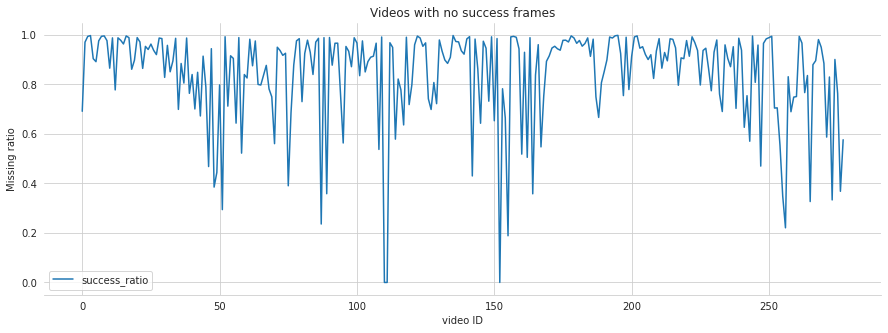

In [70]:
df_success_ratios.plot(figsize=(15,5))
plt.title("Videos with no success frames")
plt.xlabel('video ID')
plt.ylabel('Missing ratio')
plt.show()

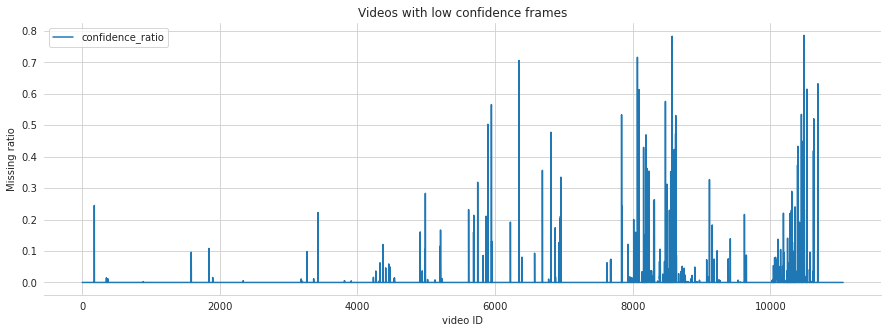

In [71]:
df_confidence_ratios.plot(figsize=(15,5))
plt.title("Videos with low confidence frames")
plt.xlabel('video ID')
plt.ylabel('Missing ratio')
plt.show()

## Clean the data

### Remove all files with too many missing frames

In [46]:
threshold = 0.9
filenames_to_remove = df_success_ratios[df_success_ratios.success_ratio <= threshold].filename
filenames_to_keep = df_success_ratios[df_success_ratios.success_ratio > threshold].filename
df_clean_success = df[df.filename.isin(filenames_to_remove) == False]

### Inspect result

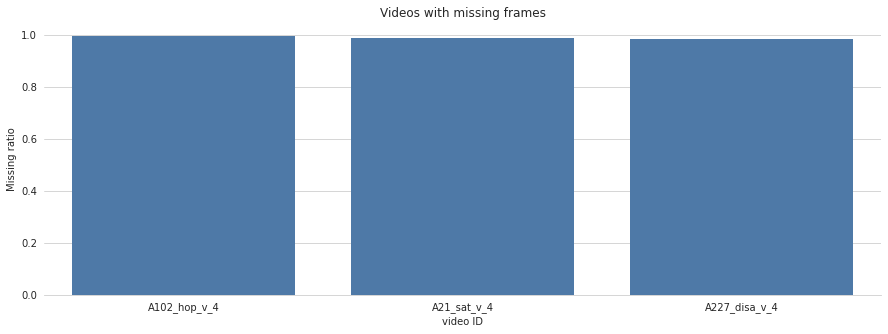

In [128]:
ratios = []

for filename, df_filename in df.groupby('filename'):
    successful = (df_filename['success'] == 1).sum()
    total = df_filename.shape[0]    
    ratio = successful/total 
    if ratio < 1:
        
        ratios.append({"filename": filename,
                      "ratio": ratio})
        
        
ratios = pd.DataFrame.from_records(ratios)
ratios = ratios.sort_values(by='ratio', ascending=False)

plt.figure(figsize=(15,5))
sns.barplot(ratios['filename'], ratios['ratio'], saturation=sns_saturation, color=blue_rgb)
plt.title("Videos with missing frames")
plt.xlabel('video ID')
plt.ylabel('Missing ratio')
plt.show()

In [134]:
filenames_to_keep.iloc[-1]

'A227_disa_v_4'

## Interpolate the missing values for remaining files

In [195]:
# Lets start by looking at an example of missing values
# select the one with the most missing values
df1 = df[df['filename'] == filenames_to_keep.iloc[-1]]

In [196]:
df1[df1['confidence'] != 1]

,filename,video_id,emotion_1,emotion_1_id,frame,success,confidence,AU01_r,AU02_r,AU04_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
65425,A227_disa_v_4,A227,disa,37,199,0,0,0.0,0.0,0.17,...,0.45,0.26,0.60,0.0,0.82,0.0,0.77,0.69,0.47,0.24
65427,A227_disa_v_4,A227,disa,37,201,0,0,0.0,0.0,0.00,...,0.50,0.16,0.34,0.0,0.89,0.0,0.82,0.49,0.44,0.00


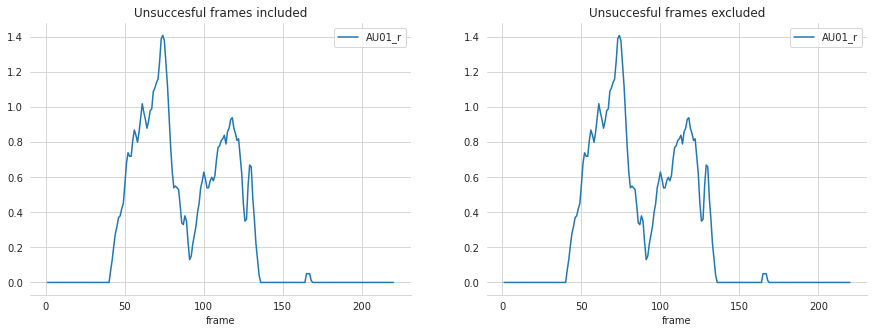

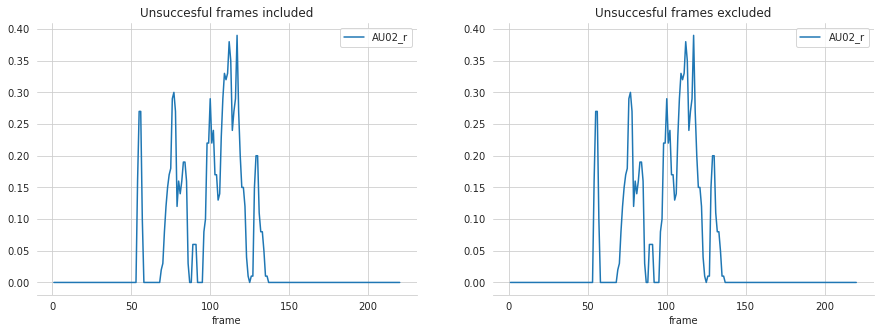

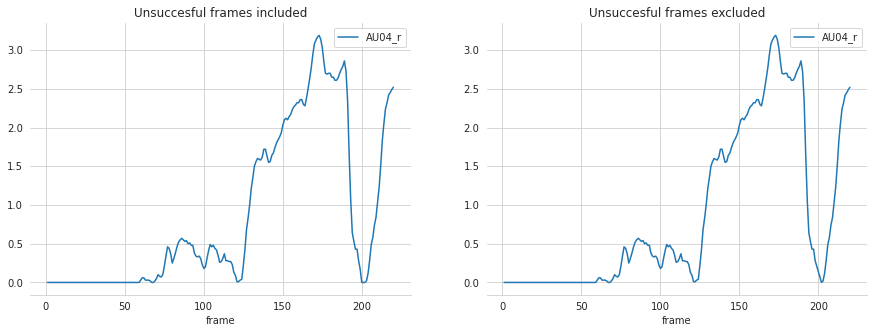

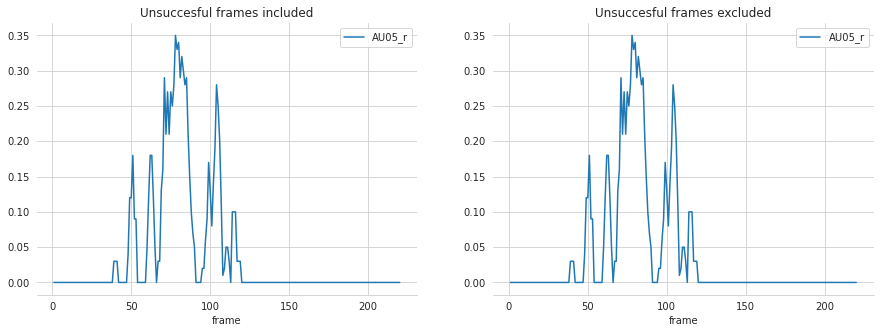

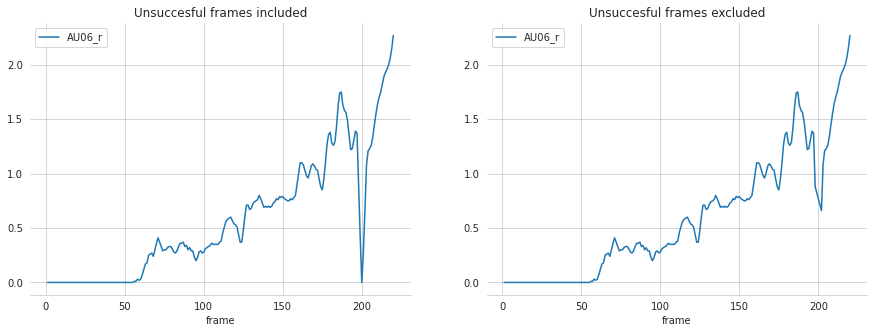

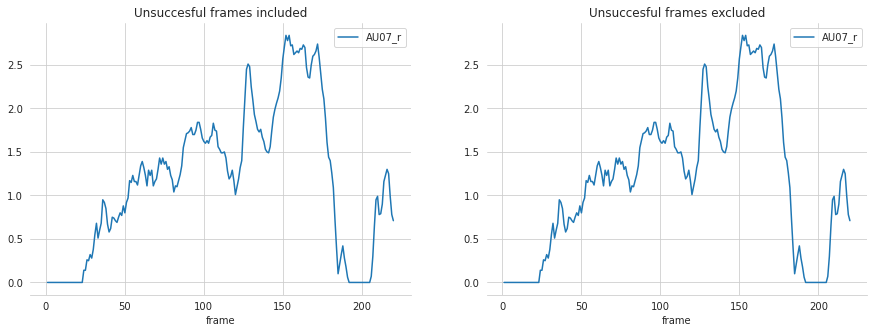

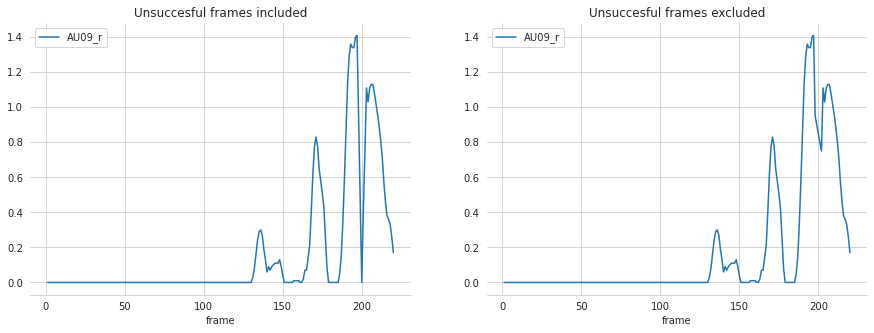

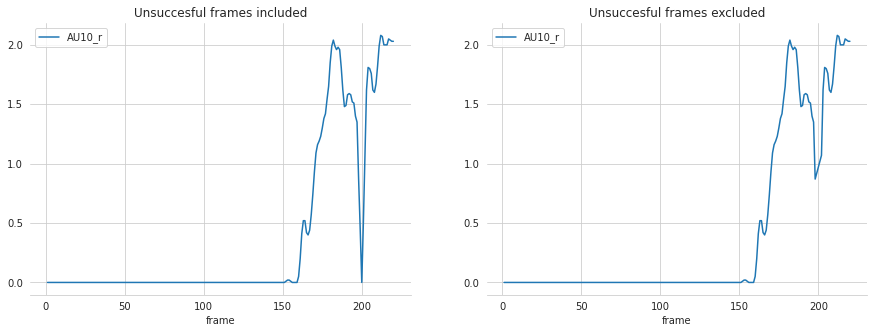

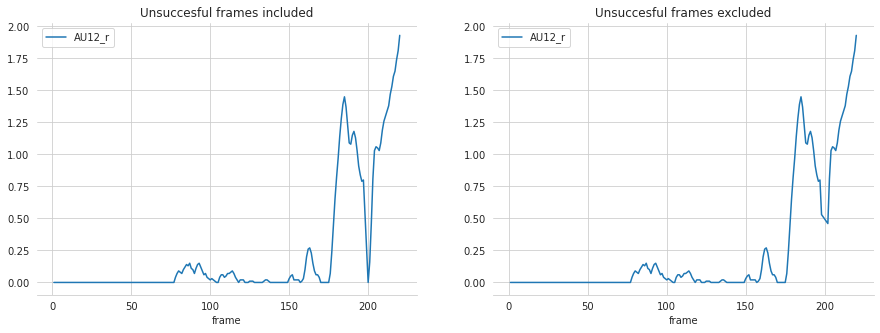

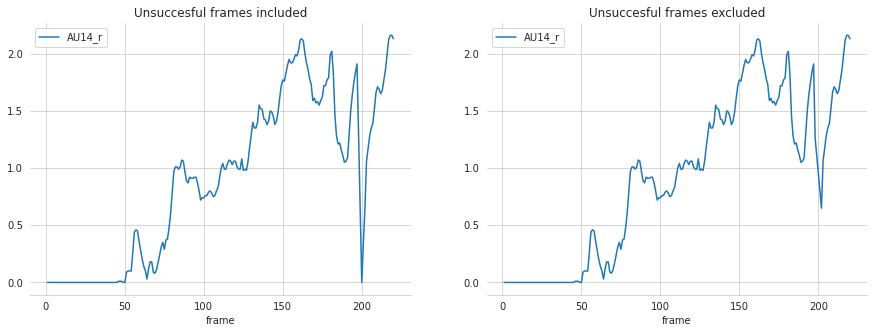

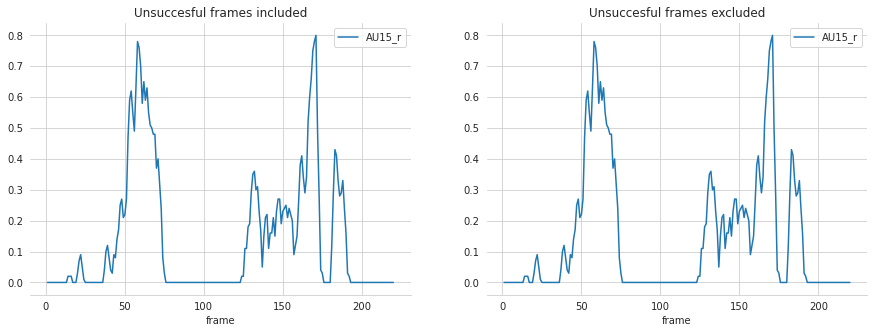

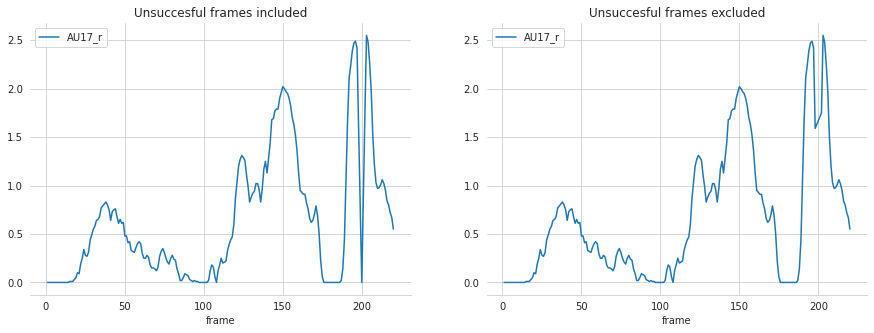

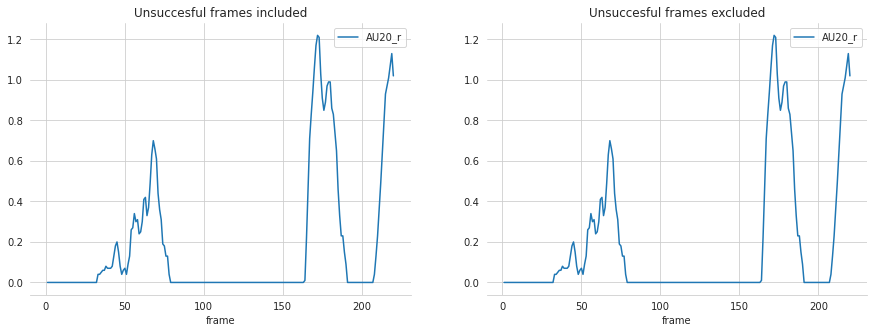

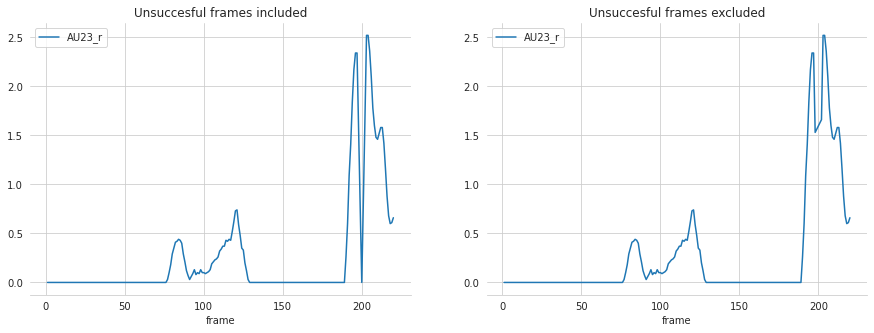

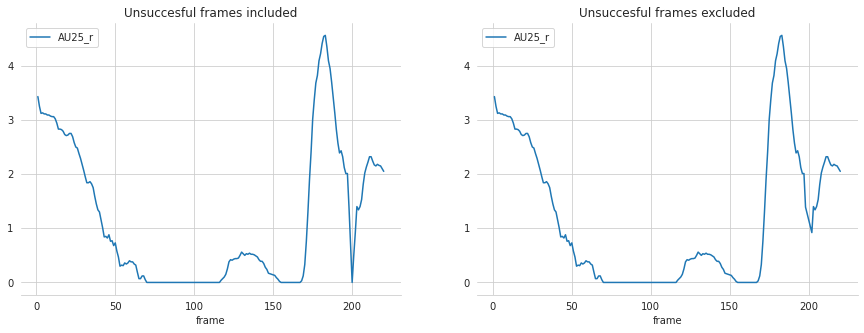

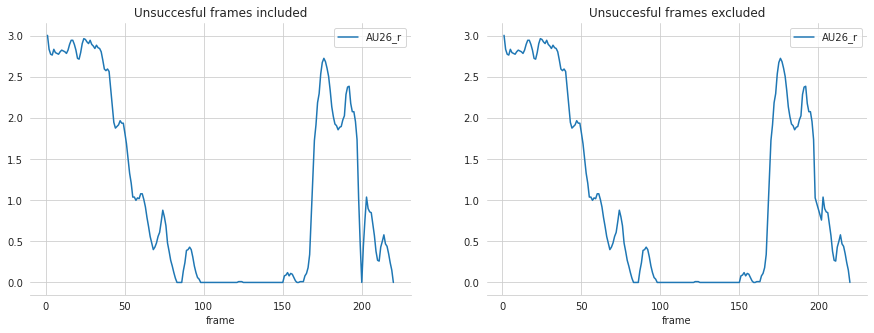

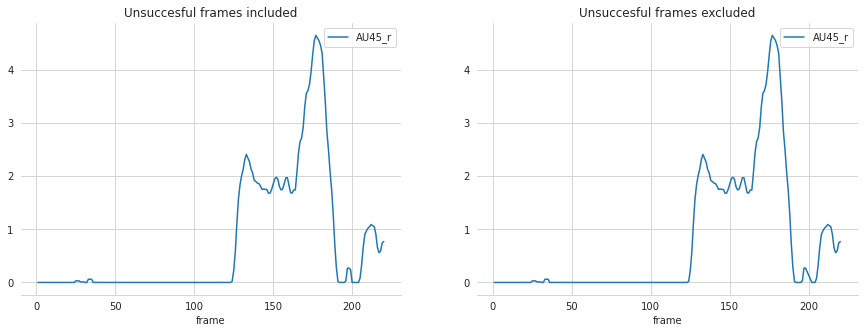

In [177]:
for au in AU_COLS:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].set_title("Unsuccesful frames included")
    axes[1].set_title("Unsuccesful frames excluded")

    
    df1.plot(x = 'frame', y = au, ax=axes[0], figsize=(15, 5))
    
    df1_success = df1[df1['success'] == 1]
    df1_success.plot(x = 'frame', y = au, ax=axes[1], figsize=(15, 5))

In [182]:
df1[df1['success'] == 0]

,filename,video_id,emotion_1,emotion_1_id,frame,success,confidence,AU01_r,AU02_r,AU04_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
65425,A227_disa_v_4,A227,disa,37,199,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65426,A227_disa_v_4,A227,disa,37,200,0,1,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
65427,A227_disa_v_4,A227,disa,37,201,0,0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [181]:
for au in AU_COLS:
    df1.loc[df1["success"] == 0, au] = np.NaN
    #df1.loc[df1[au]].interpolate(method='linear')


In [184]:
df1 = df1.interpolate(method='linear')

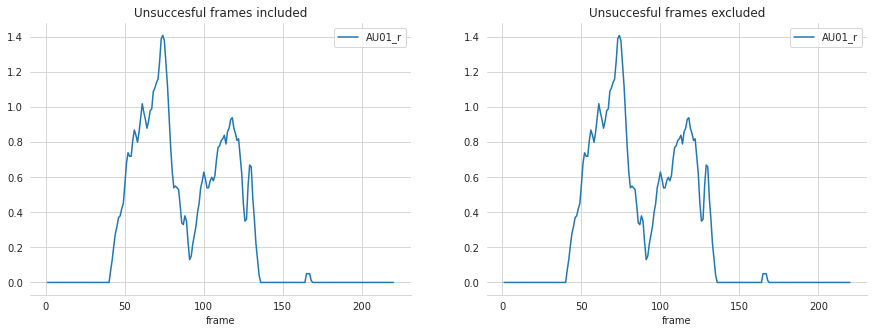

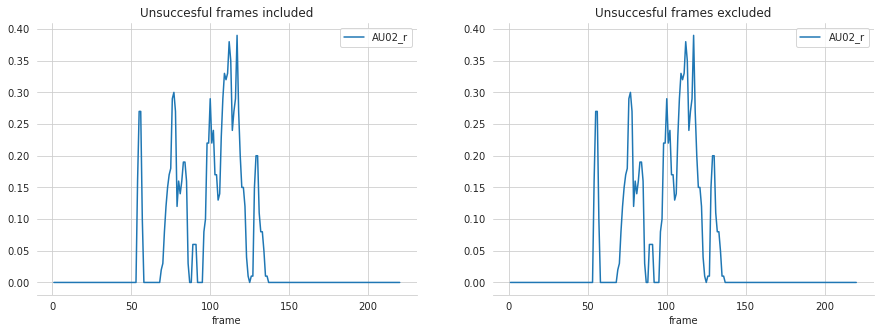

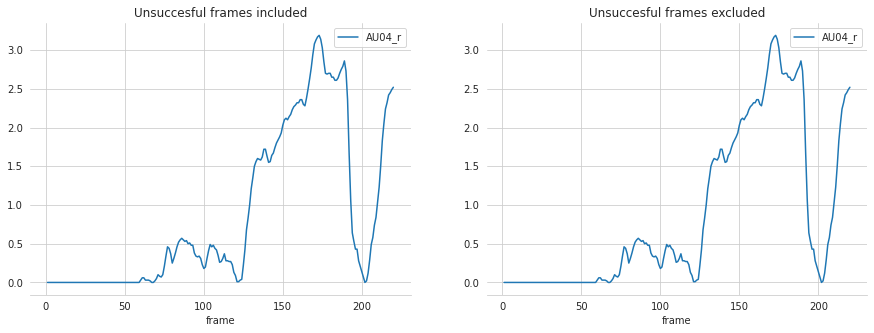

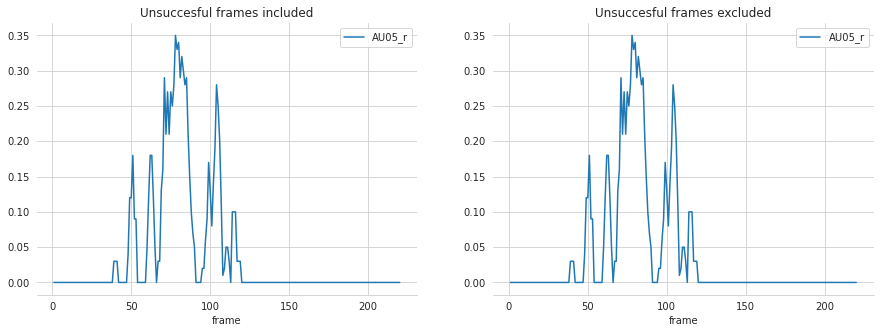

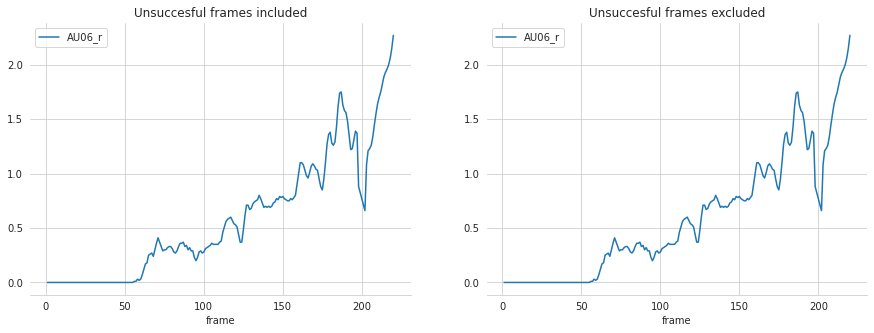

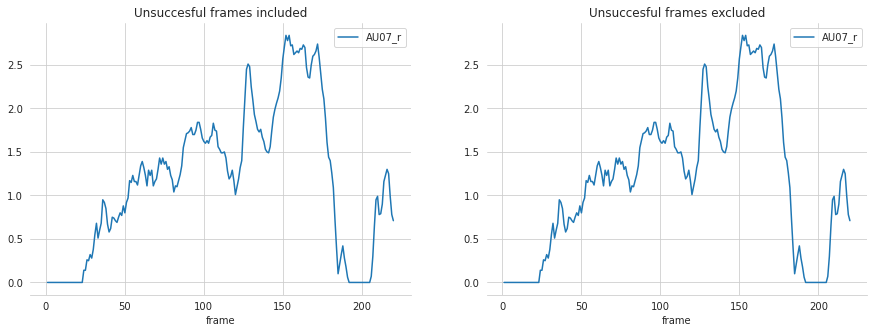

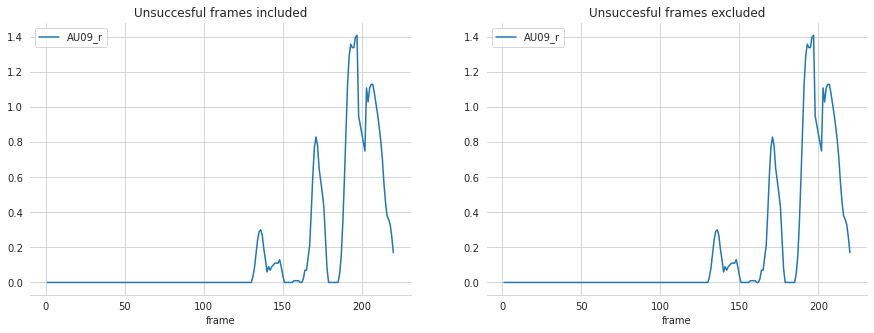

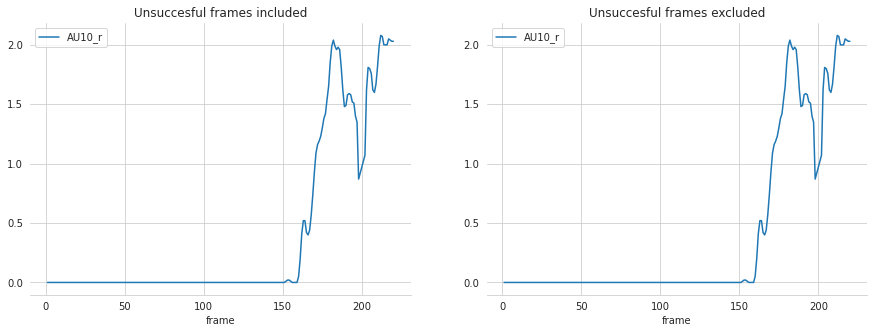

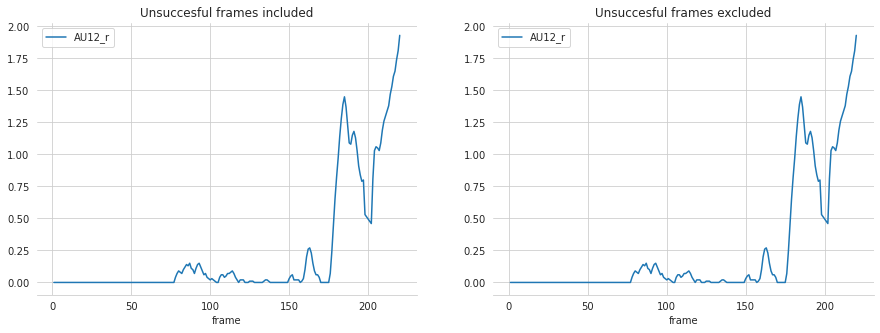

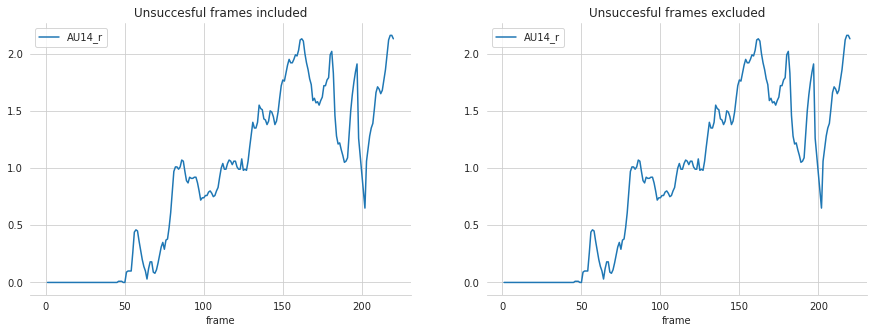

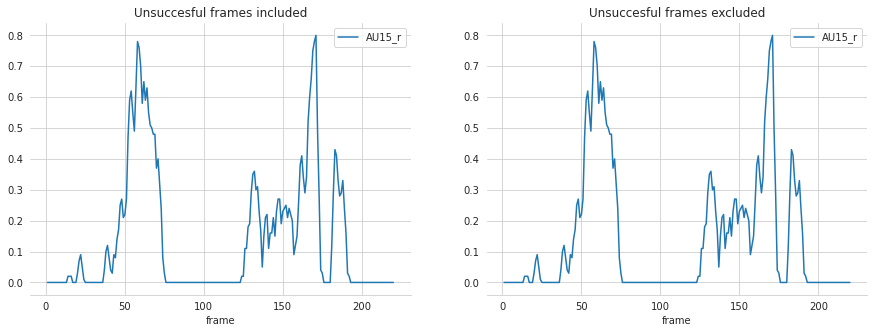

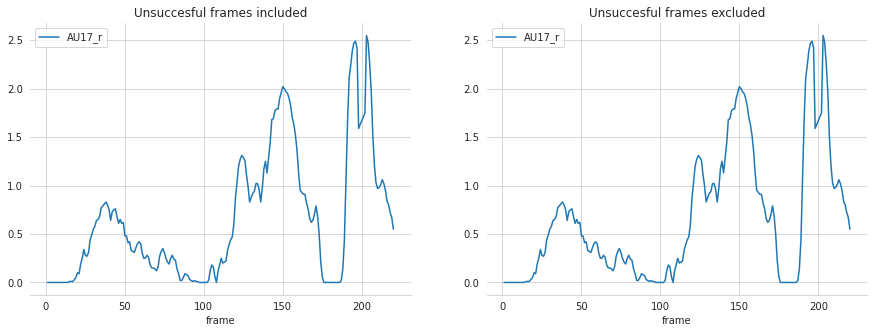

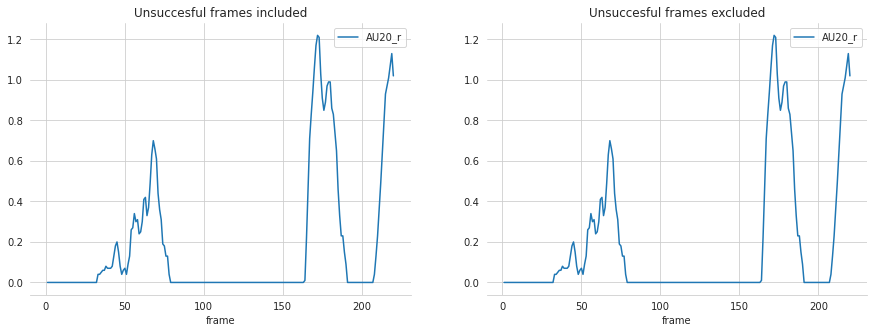

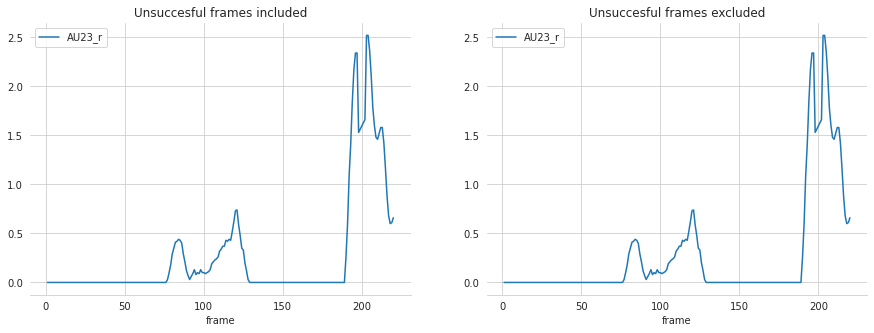

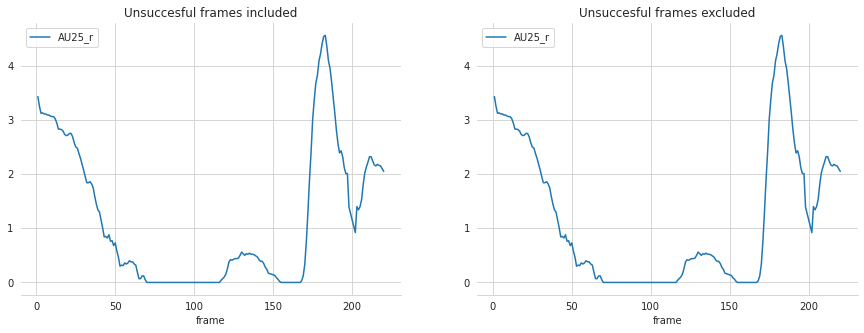

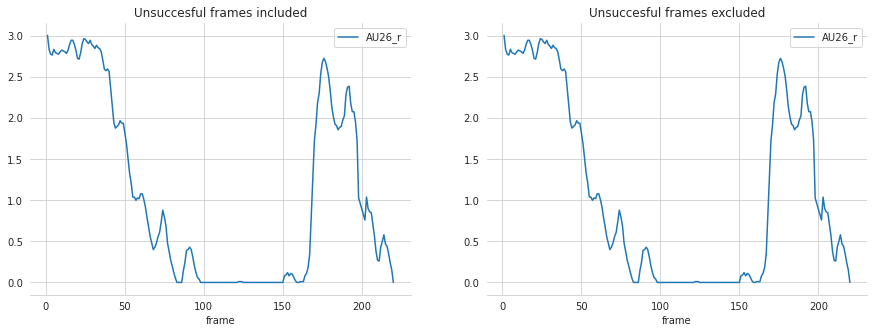

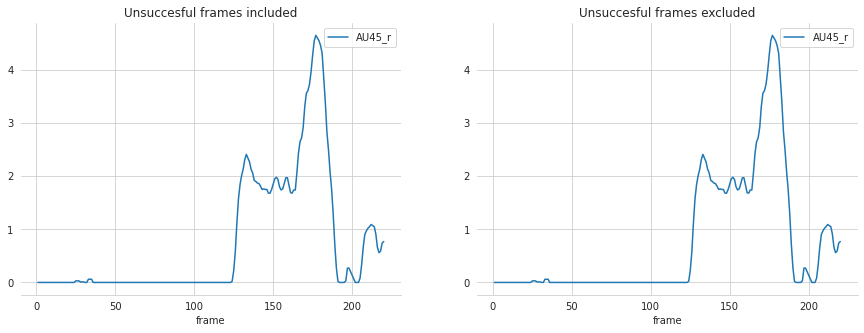

In [187]:
for au in AU_COLS:
    fig, axes = plt.subplots(nrows=1, ncols=2)
    axes[0].set_title("Unsuccesful frames included")
    axes[1].set_title("Unsuccesful frames excluded")

    
    df1.plot(x = 'frame', y = au, ax=axes[0], figsize=(15, 5))
    
    df1_success = df1[df1['success'] == 1]
    df1_success.plot(x = 'frame', y = au, ax=axes[1], figsize=(15, 5))

In [172]:
# on our data, impute the missing values using rolling window method
dataset['Customers_L']= dataset['Customers'].interpolate(method='linear')
# plot the complete dataset
plt.plot(dataset['Customers_L'], color='blue')
# add the tittle of our plot as Linear interpolation
plt.title('Linear interpolatoin')
# print the plot
plt.show()

,filename,video_id,emotion_1,emotion_1_id,frame,success,confidence,AU01_r,AU02_r,AU04_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
65227,A227_disa_v_4,A227,disa,37,1,1,1,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,3.43,3.01,0.00
65228,A227_disa_v_4,A227,disa,37,2,1,1,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,3.25,2.84,0.00
65229,A227_disa_v_4,A227,disa,37,3,1,1,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,3.12,2.78,0.00
65230,A227_disa_v_4,A227,disa,37,4,1,1,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,3.13,2.77,0.00
65231,A227_disa_v_4,A227,disa,37,5,1,1,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,3.11,2.84,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65442,A227_disa_v_4,A227,disa,37,216,1,1,0.0,0.0,2.32,...,2.00,1.61,1.99,0.0,0.84,0.97,0.88,2.18,0.44,0.66
65443,A227_disa_v_4,A227,disa,37,217,1,1,0.0,0.0,2.42,...,2.05,1.65,2.12,0.0,0.80,1.01,0.68,2.16,0.35,0.56
65444,A227_disa_v_4,A227,disa,37,218,1,1,0.0,0.0,2.45,...,2.04,1.74,2.16,0.0,0.72,1.07,0.60,2.15,0.24,0.59
65445,A227_disa_v_4,A227,disa,37,219,1,1,0.0,0.0,2.49,...,2.03,1.81,2.16,0.0,0.67,1.13,0.61,2.10,0.15,0.74


In [150]:
df1

,filename,video_id,emotion_1,emotion_1_id,frame,success,confidence,AU01_r,AU02_r,AU04_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
65227,A227_disa_v_4,A227,disa,37,1,1,1,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,3.43,3.01,0.00
65228,A227_disa_v_4,A227,disa,37,2,1,1,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,3.25,2.84,0.00
65229,A227_disa_v_4,A227,disa,37,3,1,1,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,3.12,2.78,0.00
65230,A227_disa_v_4,A227,disa,37,4,1,1,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,3.13,2.77,0.00
65231,A227_disa_v_4,A227,disa,37,5,1,1,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.00,0.00,3.11,2.84,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65442,A227_disa_v_4,A227,disa,37,216,1,1,0.0,0.0,2.32,...,2.00,1.61,1.99,0.0,0.84,0.97,0.88,2.18,0.44,0.66
65443,A227_disa_v_4,A227,disa,37,217,1,1,0.0,0.0,2.42,...,2.05,1.65,2.12,0.0,0.80,1.01,0.68,2.16,0.35,0.56
65444,A227_disa_v_4,A227,disa,37,218,1,1,0.0,0.0,2.45,...,2.04,1.74,2.16,0.0,0.72,1.07,0.60,2.15,0.24,0.59
65445,A227_disa_v_4,A227,disa,37,219,1,1,0.0,0.0,2.49,...,2.03,1.81,2.16,0.0,0.67,1.13,0.61,2.10,0.15,0.74


In [152]:
df1[df1['success'] == 0]

,filename,video_id,emotion_1,emotion_1_id,frame,success,confidence,AU01_r,AU02_r,AU04_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
65425,A227_disa_v_4,A227,disa,37,199,0,0,0.0,0.0,0.17,...,0.45,0.26,0.60,0.0,0.82,0.0,0.77,0.69,0.47,0.24
65426,A227_disa_v_4,A227,disa,37,200,0,1,0.0,0.0,0.00,...,0.00,0.00,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00
65427,A227_disa_v_4,A227,disa,37,201,0,0,0.0,0.0,0.00,...,0.50,0.16,0.34,0.0,0.89,0.0,0.82,0.49,0.44,0.00


## Number of frames for every filename

Number of frames for every filename


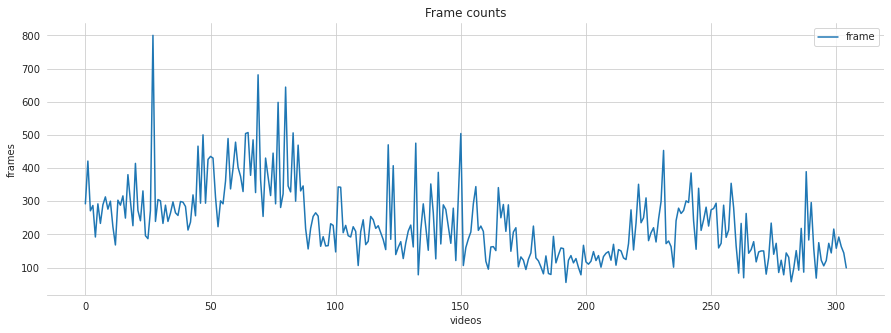

In [67]:
print("Number of frames for every filename")
frame_counts = df[['frame','filename']].groupby(["filename"]).frame.nunique().reset_index()
frame_counts.plot(figsize=(15,5))
plt.title("Frame counts")
plt.xlabel('videos')
plt.ylabel('frames')
plt.show()

# From time series data to average features

# Normalize training set

Merge on filename index... Merge with metadata afterwards...

A way to normalize the input features/variables is the Min-Max scaler. By doing so, all features will be transformed into the range [0,1] meaning that the minimum and maximum value of a feature/variable is going to be 0 and 1, respectively.

In [28]:
from sklearn import preprocessing

# get the metadata from original dataframe
df_metadata = df[['filename', "frame", "video_id", "emotion_1_id"]]

# get only features
X = df.drop(columns=['filename', "frame", "video_id", "emotion_1", "emotion_1_id"])

min_max_scaler = preprocessing.MinMaxScaler()

# Fit and transform features
X_scaled = min_max_scaler.fit_transform(X)

# Create a dataframe from normalized features
X_scaled_df = pd.DataFrame(data=X_scaled, columns=X.columns.to_list())

# join back on index with filename dataframe
X_scaled_df = df_metadata.join(X_scaled_df)

In [29]:
X_scaled_df

,filename,frame,video_id,emotion_1_id,AU01_r,AU02_r,AU04_r,AU05_r,AU06_r,AU07_r,...,AU10_r,AU12_r,AU14_r,AU15_r,AU17_r,AU20_r,AU23_r,AU25_r,AU26_r,AU45_r
0,A227_neg_sur_v_4,1,A227,11,0.000,0.000000,0.000000,0.000000,0.000000,0.000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.088643,0.000,0.144,0.614610,0.0
1,A227_neg_sur_v_4,2,A227,11,0.000,0.000000,0.000000,0.077135,0.000000,0.000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.063712,0.012,0.164,0.526448,0.0
2,A227_neg_sur_v_4,3,A227,11,0.000,0.000000,0.000000,0.129477,0.000000,0.000,...,0.000000,0.000000,0.000000,0.0,0.000000,0.077562,0.020,0.186,0.483627,0.0
3,A227_neg_sur_v_4,4,A227,11,0.000,0.000000,0.000000,0.165289,0.000000,0.010,...,0.000000,0.000000,0.000000,0.0,0.000000,0.099723,0.018,0.214,0.450882,0.0
4,A227_neg_sur_v_4,5,A227,11,0.000,0.000000,0.000000,0.099174,0.000000,0.010,...,0.000000,0.000000,0.000000,0.0,0.000000,0.110803,0.018,0.232,0.471033,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71403,A303_sad_v_4,82,A303,6,0.200,0.018109,0.114286,0.000000,0.196617,0.206,...,0.430998,0.256818,0.089888,0.0,0.228866,0.000000,0.016,0.000,0.226700,0.0
71404,A303_sad_v_4,85,A303,6,0.126,0.088531,0.085714,0.002755,0.063425,0.028,...,0.199575,0.113636,0.069663,0.0,0.152577,0.000000,0.000,0.000,0.115869,0.0
71405,A303_sad_v_4,87,A303,6,0.130,0.090543,0.104082,0.079890,0.038055,0.000,...,0.178344,0.100000,0.078652,0.0,0.138144,0.000000,0.000,0.000,0.118388,0.0
71406,A303_sad_v_4,90,A303,6,0.312,0.211268,0.157143,0.173554,0.000000,0.000,...,0.142251,0.086364,0.256180,0.0,0.309278,0.000000,0.000,0.000,0.292191,0.0


In [30]:
save_path = os.path.join(output_path, 'video_data_time_series.csv')
X_scaled_df.to_csv(save_path, index=None, header=True)